In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

# 1 -  Bias Variance Decomposition

In [2]:
from sklearn.datasets import make_blobs
def toy_data(n):
    X, y = make_blobs(n_samples=[n,n], centers=[[0,0],[2,2]], random_state=42)
    return X,y

In [3]:
X, y = toy_data(500)

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

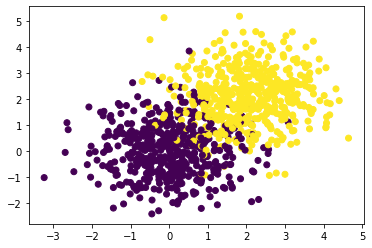

In [5]:
plt.scatter(X[:,0],X[:,1],c=y)

In [6]:
from scipy.stats import multivariate_normal
def pdf(X,mean,sigma):
    return multivariate_normal.pdf(X, mean=[mean,mean],cov=[[sigma,0],[0,sigma]])

In [7]:
def computeybar(X):
    p0 = pdf(X,0,1)
    p1 = pdf(X,2,1)
    return [1 if p1[i]>p0[i] else 0 for i in range(len(X))]

In [8]:
#Referred the following link
#https://medium.com/analytics-vidhya/bias-variance-trade-off-in-datascience-and-calculating-with-python-766158812c46
#https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html

In [9]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge

In [10]:
def computehbar(X_test,alpha,n):
    h = [0 for i in range(len(X_test))]
    for i in range(n):
        X,y = toy_data(500)
        r = KernelRidge(alpha=alpha,kernel='rbf')
        r.fit(X,y)
        h.append(r.predict(X_test))
    
    return sum(h)/n

In [11]:
def computevariance(X_test,alpha,hbar, n):
    var = []
    for i in range(n):
        X,y = toy_data(500)
        r = KernelRidge(alpha=alpha,kernel='rbf')
        r.fit(X,y)
        pred = r.predict(X_test)
        var.append((pred-hbar)**2)
    return np.mean(var)/n

In [12]:
def biasvariancedemo(n):
    alphas = np.arange(-6, 0.5, 0.5)
    biass=[]
    noiss = []
    varss = []
    bvn = []
    t_error = []
    for alpha in alphas:
        s = 0
        X_test,y_test = toy_data(500)
        for j in range(n):
            X,y = toy_data(50)
            r = KernelRidge(alpha=alpha,kernel='rbf')
            r.fit(X,y)
            pred=r.predict(X)
            s+=np.mean((pred-y)**2)
        s/=n
    
        ybar = computeybar(X_test)
        noise = np.mean((y_test-ybar)**2)
        hbar = computehbar(X_test,alpha,n)
        bias = np.mean((hbar-ybar) ** 2)

        variance = computevariance(X_test,alpha,hbar,n)
        varss.append(variance)
        biass.append(bias)
        noiss.append(noise)
        bvn.append(bias+variance+noise)
        t_error.append(s)
#         print('alpha:{},bias:{},variance:{},noise:{},b+v+n:{},test_error:{}'.format(alpha,bias,variance,noise,(bias+variance+noise),s))
    return biass, varss,noiss,bvn,t_error

In [13]:
bias,var,noise,bvn,t_error = biasvariancedemo(25)

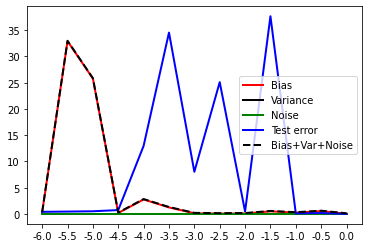

In [14]:
# plot results
alphas = np.arange(-6, 0.5, 0.5)
n_alphas = len(alphas)
plt.plot(bias[:n_alphas],c='r',linestyle='-',linewidth=2)
plt.plot(var[:n_alphas],c='k', linestyle='-',linewidth=2)
plt.plot(noise[:n_alphas],c='g', linestyle='-',linewidth=2)
plt.plot(t_error[:n_alphas],c='b', linestyle='-',linewidth=2)
plt.plot(bvn[:n_alphas],c='k', linestyle='--',linewidth=2)
plt.legend(["Bias","Variance","Noise","Test error","Bias+Var+Noise"])
plt.xticks([i for i in range(n_alphas)],alphas);

# 2 -  SVM Classifier

In [15]:
data = []
with open('hw3_data2.txt') as f:
    lines = f.readlines()
    for line in lines:
        line = (line.rstrip().split(','))
        data.append(line)

In [16]:
df = pd.DataFrame(data,columns=['class','x1','x2'])

In [17]:
df['x1'],df['x2'] = df.x1.astype(float), df.x2.astype(float)

In [18]:
df['class'] = np.where(df['class']=='+',1,-1)

In [19]:
df.head(5)

,class,x1,x2
0,1,1.607874,9.247557
1,1,3.003258,6.610258
2,1,4.069008,18.327280
3,1,0.407198,14.835517
4,1,13.747305,8.219991


In [20]:
X,y = df.drop('class',axis=1),df['class']

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X.values,y.values,random_state=42,test_size=0.3)

SVC works better for this data because the data is not linearly separable here, and SVC uses a kernel which would be able to classify non linear data.

In [22]:
from sklearn.svm import SVC

In [23]:
#Referred the following link
#https://stackoverflow.com/questions/26962159/how-to-use-a-custom-svm-kernel
def rbf_kernel(a,b):
    return np.exp(-np.sum((a-b)**2))

def gaussian_matrix(X):
    n = len(X)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i][j] = rbf_kernel(X[i], X[j])
    return K


svc = SVC(kernel="precomputed")
mat = gaussian_matrix(X.values)
svc.fit(mat,y)
acc = accuracy_score(y,svc.predict(mat))
print(acc)

0.9616666666666667


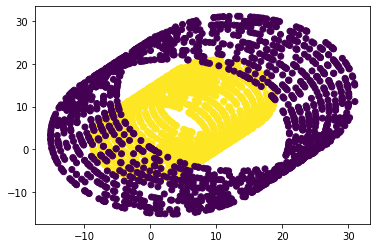

In [24]:
plt.scatter(X.values[:, 0], X.values[:, 1], c=y)

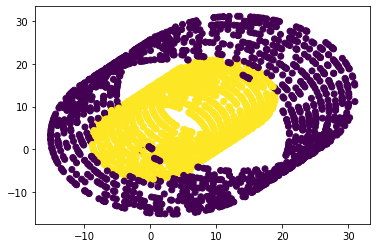

In [25]:
#Plotting predicted values
plt.scatter(X.values[:,0], X.values[:,1], c=svc.predict(mat))

# 3 - Gaussian Process

In [26]:
df = pd.read_excel('Concrete_Data.xls')

In [27]:
def RBF(X1,X2,s,h):
    n = len(X1)
    m = len(X2)
    K = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            K[i][j] = s*np.exp(-np.sum((X1[i]-X2[j])**2)/2*h**2)
    return K

In [28]:
label = df.columns[-1]
X,y = df.drop(label,axis=1), df[label]

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [30]:
def gp_mean_variances(X_train,y_train,X_test,s,h):
    n = X_train.shape[0]
    K = RBF(X_train,X_train,s,h)
    I = np.identity(n)
    sigma2 = 0.01*np.std(y_train)
    L = (K+sigma2*I)
    inv_L = np.linalg.inv(L)
    alpha = inv_L @ y_train
    k_ = RBF(X_test,X_train,s,h)
    mean = k_ @ alpha
    var = RBF(X_test,X_test,s,h) - k_@inv_L@RBF(X_train,X_test,s,h)
    return mean, var

In [31]:
means,varss = gp_mean_variances(X_train.values,y_train.values,X_test.values,np.std(y_train),np.linalg.norm(np.std(X_train)))

In [32]:
#Referred the following links
#https://towardsdatascience.com/gaussian-process-regression-from-first-principles-833f4aa5f842
#https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/gaussian_process/_gpr.py
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from scipy.optimize import minimize, brute
class GaussianRegressor(BaseEstimator):
    def __init__(self,s=0,h=1):
        self.s = s
        self.h = h
    def get_params(self, deep=True):
        return {"h": self.h, "s": self.s}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def RBF(self,X1,X2,s,h):
        n = len(X1)
        m = len(X2)
        K = np.zeros((n,m))
        for i in range(n):
            for j in range(m):
                K[i][j] = s*np.exp(-np.sum((X1[i]-X2[j])**2)/2*h**2)
        return K
    
    def log_likelihood(self,theta):
        s = theta[0]
        h = theta[1]
        n = self.X_.shape[0]
        I = np.identity(n)
        sigma2 = 0.01*np.std(y_train)
        K = self.RBF(self.X_,self.X_,s,h) + sigma2*I
        inv_K = np.linalg.inv(K)
        n_log_likelihood =  -n/2*np.log(2*math.pi) - 1/2*self.y_.T @ inv_K @ self.y_ - 1/2*np.log(np.linalg.det(K))
        return n_log_likelihood
    
    
    def fit(self,X,y):
        self.X_ = X
        self.y_ = y
        s,h = np.logspace(-1,1,10)*np.std(self.y_), np.logspace(-1,1,10)*np.linalg.norm(np.std(self.X_))
        params = []
        for i in range(10):
            params.append((s[i],h[i]))
        try:
            res = brute(self.log_likelihood,(slice(s[0],s[-1]),slice(h[0],h[-1])))
        except:
            print(res)
            
        return self
    
    def gp_mean_variances(self,X_train,y_train,X_test,s,h):
        n = X_train.shape[0]
        K = self.RBF(X_train,X_train,s,h)
        I = np.identity(n)
        sigma2 = 0.01*np.std(y_train)
        L = (K+sigma2*I)
        inv_L = np.linalg.inv(L)
        alpha = inv_L @ y_train
        k_ = self.RBF(X_test,X_train,s,h)
        mean = k_ @ alpha
        var = self.RBF(X_test,X_test,s,h) - k_@inv_L@self.RBF(X_train,X_test,s,h)
        return mean, var

    
    def predict(self,X_test):
        means,varss = self.gp_mean_variances(self.X_,self.y_,X_test,self.s,self.h)
        self.y_pred = means
        return means


Tried fitting it using scipy to minimize log likelihood but it was taking a lot of time, so just looped through the possible
values of s and h to find the optimal params.

In [33]:
# def def hyper_parameter_search(X_train,y_train,h,s):
#     H,S = np.logspace(-1,1,10)*np.linalg.norm(np.std(X_train)), np.logspace(-1,1,10)*np.std(y_train)
#    GaussianRegressor GaussianRegressor(S,H)
#     gp.fit(X_train,y_train)    

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
def log_likelihood(X_train,y_train,theta):
        s = theta[0]
        h = theta[1]
        n = X_train.shape[0]
        I = np.identity(n)
        sigma2 = 1e-10*np.std(y_train)
        K = np.linalg.cholesky(RBF(X_train,X_train,s,h) + sigma2*I)
        inv_K = np.linalg.inv(K)
        n_log_likelihood =  -n/2*np.log(2*math.pi) - 1/2*y_train.T @ inv_K @ y_train - 1/2*np.log(np.linalg.det(K))
        return n_log_likelihood

def hyper_parameter_search(X_train,y_train,h,s):
    H,S = np.logspace(-1,1,10)*np.linalg.norm(np.std(X_train)), np.logspace(-1,1,10)*np.std(y_train)
    res = []
    for h in H:
        for s in S:
            res.append((s,h,log_likelihood(X_train,y_train,(s,h))))
    return max(res,key=lambda x:x[2])

In [35]:
tuned_s, tuned_h, minimal_loglikelihood = hyper_parameter_search(X_train.values,y_train.values,1,1)

In [36]:
tuned_mean, tuned_vars = gp_mean_variances(X_train.values,y_train.values,X_test.values,tuned_s,tuned_h)

In [37]:
minimal_loglikelihood

-14650903.918513987